<a href="https://colab.research.google.com/github/AY0ungKim/AI-Study/blob/main/Sequential_Data%26Recurrent_Neural_Networks_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. RNN의 Gradient exploding/vanishing 문제들

Backpropagation에서 w에 대한 gradient를 구할 때, 아래와 같은 식이 나옴


> 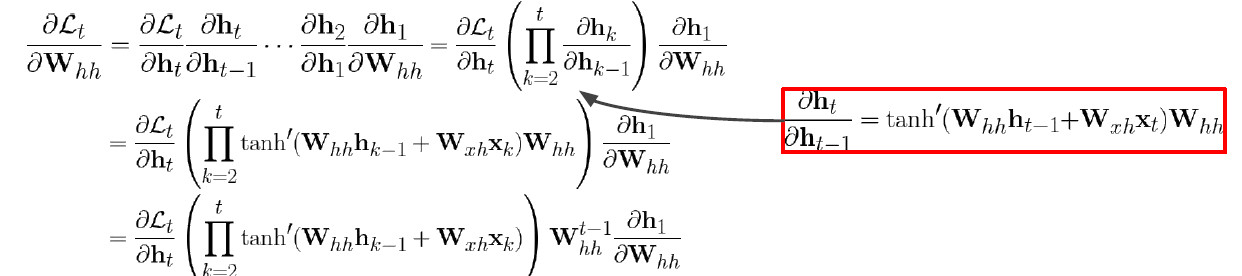

아래 각 빨간 부분은 항상 0과 1사이이므로, t-1만큼 곱해지면 gradient가 사라지고, 파란 부분도 t-1번 곱해지므로, 이 값이 1보다 크면 gradient가 exploding하고, 1보다 작으면 gradient가 vanishing한다.

> 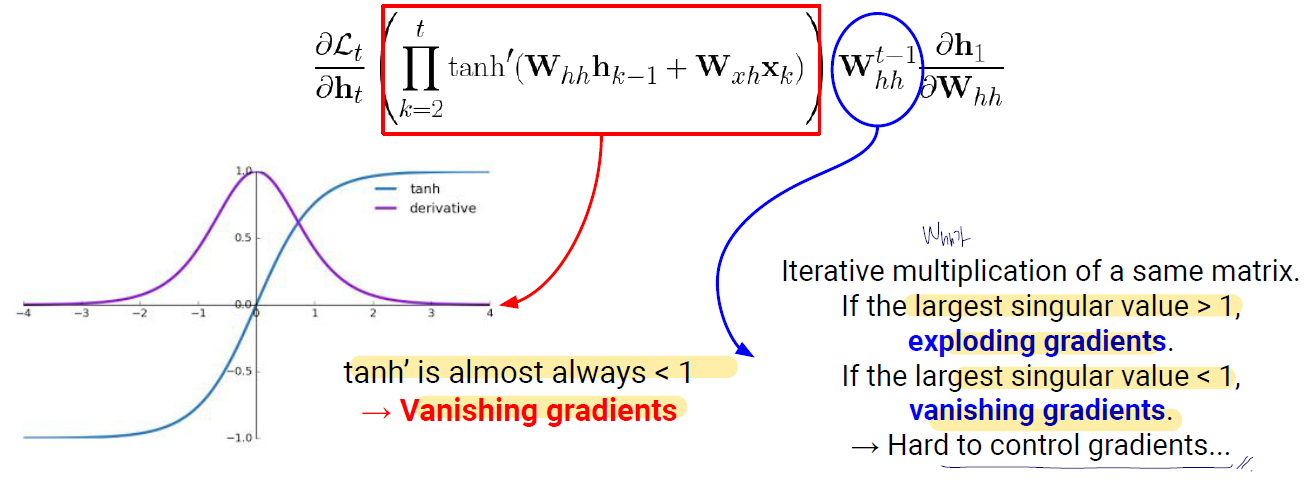

CNN에서 image를 다룰 때는, layer를 많이 안쌓으면 Xaiver initionalization 등 초기값 지정 등의 해결법이 있는데, RNN처럼 문장을 다루는 문제에서는 층이 많아져서 W를 곱해야하는 이유는 층이 많아서가 아니라 **문장의 길이가 길어서** 생김. 즉, 우리 마음대로 문장의 길이를 줄일 수 없기 때문에 **수학적으로 무조건 이 문제가 생길 수 밖에 없음.**

> 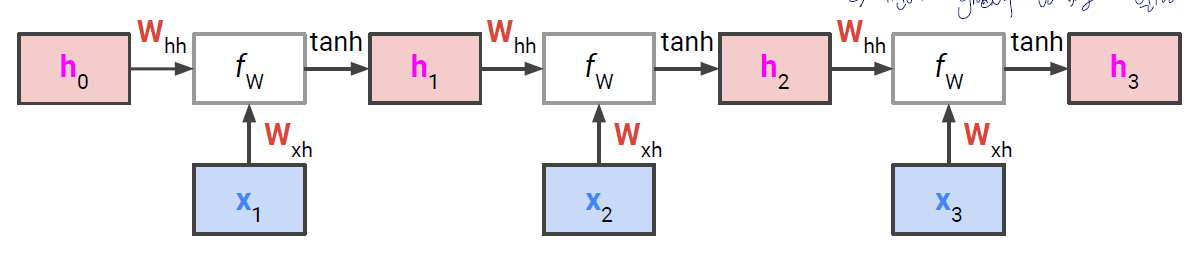

<br/>

- **Clipping** (Gradient exploding 해결)


> threshold를 정하고, 그 값보다 더 큰 gradient가 나오면 exploding하는 것을 방지하기 위해 방향은 유지하고 크기만 작게 만들어주는 방식

> 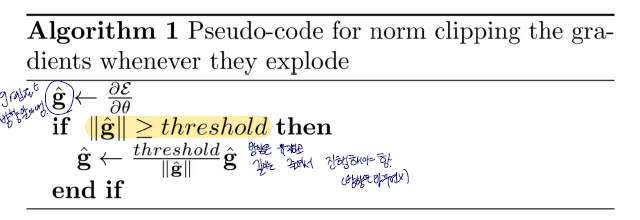

- Gradient Vanishing을 해결할 수 있는 방법은 없음. 대신, Gradient Vanishing으로 인해 생기는 longer dependence의 부재 (장기 기억 부재)의 문제를 해결하는 방법으로 LSTM 제안

## 2. Towards Modeling Longer Dependence

- Long Short Term Memory (LSTM): long-term memory를 기억할 수 있는 **cell state를 추가**하자





>  cell state를 보호하고 제어하기 위한 3개의 게이트 추가

>- Forget gate: 이전의 cell state의 값을 얼마나 잊을지에 대한 gate (h_t-1과 x_t를 받아서 sigmoid 변환을 통해 0-1 사이 값을 갖게 한다. 즉, 이전에 들어온 cell state에 1이 곱해지면 cell state를 모두 보존하라는 의미이고, 0이 곱해지면 모두 잊으라는 의미)

>- Input gate: 이번 들어온 input과 h를 이용해서 cell state에 얼마나 저장할 것인지를 결정 (해당 x input과 h_t-1로 들어온 값에 sigmoid 변환을 통해 0-1사이 값을 갖게 한다. 그리고 x input과 h_t-1로 들어온 값에 tanh를 취한 값에 해당 값을 곱해서 새로 들어온 정보를 얼마나 현재 cell state에 저장할 것인지 의미)

>- Output gate: 이번 hidden state에 얼마나 저장할지 결정

>> 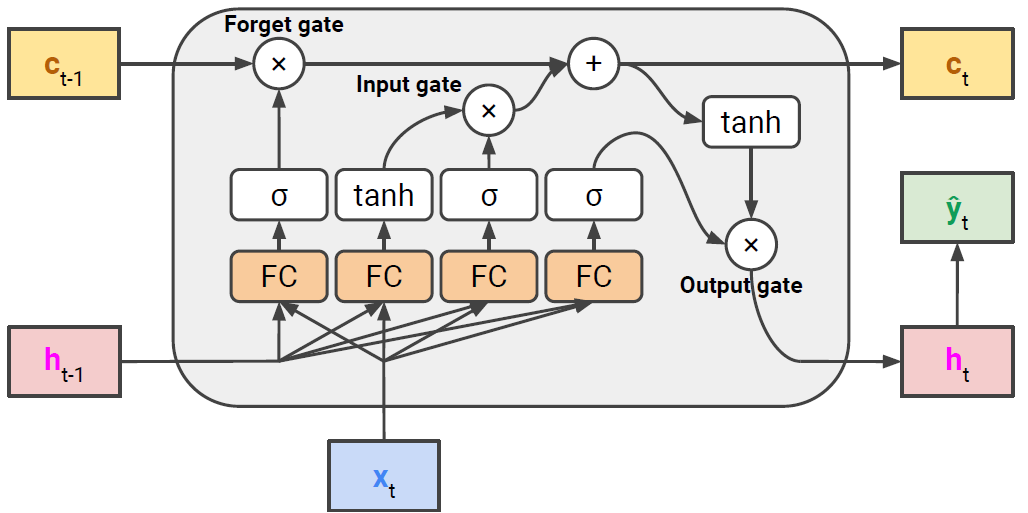

>> 식으로 나타내면 다음과 같음

>> 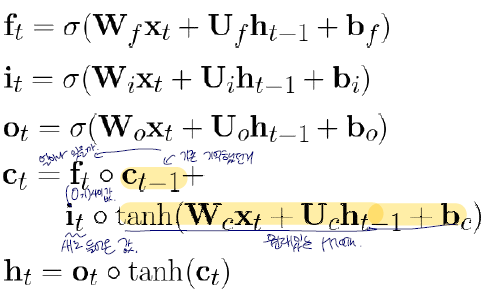

<br/>

> 의의: cell state를 추가함으로서 장기 기억을 하게 만들 수 있지만 vanishing/exploding gradient의 본질적인 문제는 해결하지 못함


<br/>

- Gated Recurrent Units (GRU): Cell state를 추가로 사용하지 않고, 더 적은 parameter를 추정하기에 계산이 훨씬 수월함

> 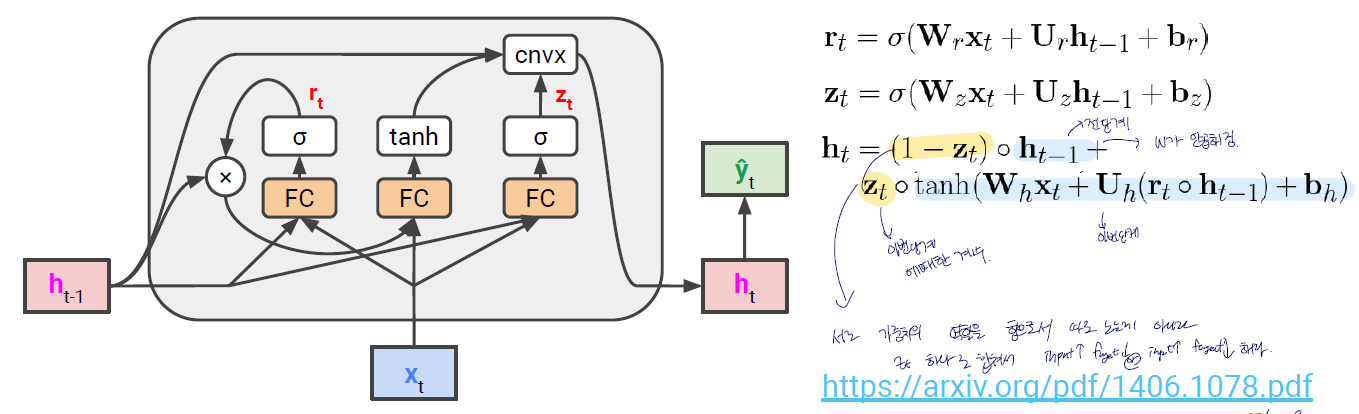


>> 이전 hidden state (h_t-1)와 현재 state에서 읽은 정보들로 만든 것의 가중치의 합이 1이 되도록 해서 (convex combination) input게이트와 forget 게이트가 따로 놀지 않도록 하나의 parameter로 줄인 것 (서로 반비례하도록)


<br/>

- 실전에서의 사용

> 일단은 LSTM을 써라. 계산 빨리 하고 싶으면 GRU도 괜찮다. gradient 문제 해결하고 싶으면 Transformer를 써라.



LSTM 코드

In [3]:
import torch
import torch.nn as nn

rnn = nn.LSTM(10, 20, 2)
input = torch.randn(5, 64, 10)
h0 = torch.randn(2, 64, 20)
c0 = torch.randn(2, 64, 20)
output, (hn, cn) = rnn(input, (h0, c0)) #RNN 코드에 cn(cell state)만 추가됨

## 3. Seq to Seq

배경: 언어 번역 시에는, 1대 1 매칭이 안되고, 언어마다 문법도 다르기에 many-to-many 방법을 사용할 수 없음.

해결: **Encoder-Decoder Structure**을 사용해서, Encoder에서는 각 input을 다 불러와서 저장을 해두고, Decoding 때 해당 state의 y가 다음 state의 input으로 들어가는 auto-regressive한 방법을 이용

> 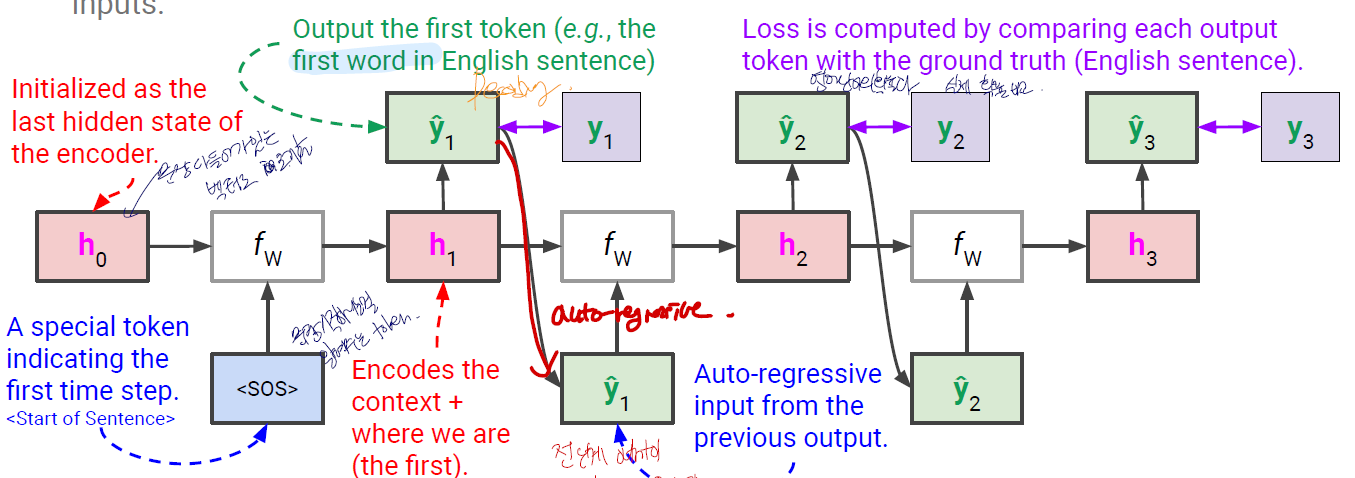

주의: 단, training 시에 틀린 답을 쭉 학습하면 다 틀려버리니까 traning 시에는 원래 정답을 다음 input으로 넣어주는 **teacher force** 시행

> 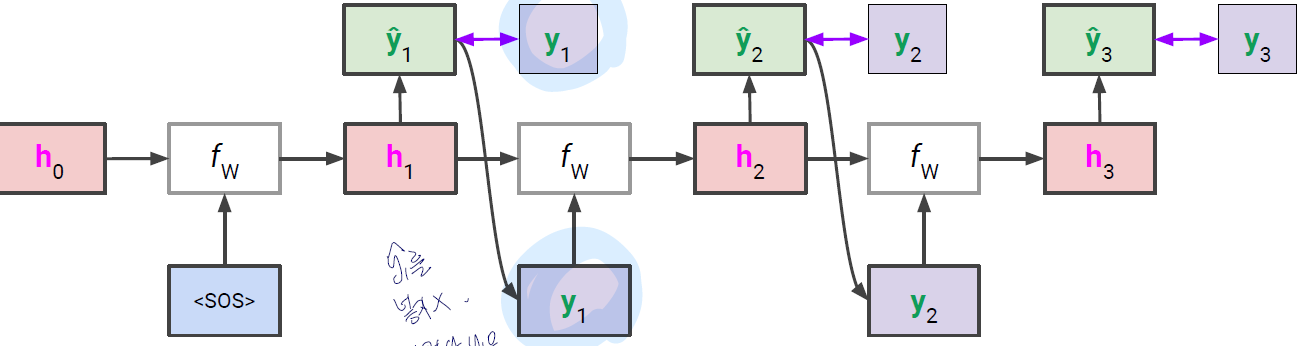

즉, encoder에서 many-to-one을, decoder에서 one-to-many를 시행



In [4]:
class EncoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p):
    super(EncoderLSTM, self).__init__()
    self.input_size = input_size # length of one-hot input
    self.embedding_size = embedding_size # dimensionality of an input token (word embedding)
    self.hidden_size = hidden_size # dimensionality of hidden representation
    self.num_layers = num_layers # Number of layers in the LSTM
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(self.input_size, self.embedding_size)
    self.LSTM = nn.LSTM(self.embedding_size, hidden_size, num_layers, dropout=p)
  def forward(self, x):
    # shape: [sequence length, batch size, embedding dims]
    embedding = self.dropout(self.embedding(x))
    # outputs shape: [sequence length, batch size, hidden_size]
    # hs, cs shape: [num_layers, batch_size, hidden_size]
    outputs, (hidden_state, cell_state) = self.LSTM(embedding)
    return hidden_state, cell_state

In [5]:
class DecoderLSTM(nn.Module):
  def __init__(self, input_size, embedding_size, hidden_size, num_layers, p, output_size):
    super(DecoderLSTM, self).__init__()
    self.input_size = input_size # length of one-hot input (input language vocab size)
    self.embedding_size = embedding_size # word embedding size
    self.hidden_size = hidden_size # dimensionality of hidden representation
    self.num_layers = num_layers # Number of layers in the LSTM
    self.output_size = output_size # length of one-hot output (output language vocab size)
    self.dropout = nn.Dropout(p)
    self.embedding = nn.Embedding(self.input_size, self.embedding_size)
    self.LSTM = nn.LSTM( self.embedding_size, hidden_size, num_layers, dropout = p)
    self.fc = nn.Linear( self.hidden_size, self.output_size)
  def forward(self, x, hidden_state, cell_state):
    x = x.unsqueeze(0) # shape of x: [1, batch_size]
    embedding = self.dropout(self.embedding(x)) # shape: [1, batch size, embedding dims]
    # outputs shape: [1, batch size, hidden_size]
    # hs, cs shape: [num_layers, batch_size, hidden_size] ← hs, cs from Encoder
    outputs, (hidden_state, cell_state) = self.LSTM(embedding, (hidden_state, cell_state))
    predictions = self.fc(outputs) # shape: [1, batch_size, output_size]
    predictions = predictions.squeeze(0) # shape: [batch_size, output_size]
    return predictions, hidden_state, cell_state

In [6]:
class Seq2Seq(nn.Module):
  def __init__(self, Encoder_LSTM, Decoder_LSTM):
    super(Seq2Seq, self).__init__()
    self.Encoder_LSTM = Encoder_LSTM
    self.Decoder_LSTM = Decoder_LSTM
  def forward(self, source, target):
    batch_size = source.shape[1] # source shape: [input language seq len, num_sentences]
    target_len = target.shape[0] # target shape: [output language seq len, num_sentences]
    target_vocab_size = len(english.vocab)
    outputs = torch.zeros(target_len, batch_size, target_vocab_size)
    hs, cs = self.Encoder_LSTM(source)
    x = target[0] # Trigger token <SOS>; shape: [batch_size]
    for i in range(1, target_len):
      output, hs, cs = self.Decoder_LSTM(x, hs, cs)
      outputs[i] = output
      x = output.argmax(1)
    return outputs # shape: [output language seq len, batch_size, target_vocab_size]